# Homework 5 - Explore Wikipedia's hyperlinks network

## Data handling

In [1]:
import scripts.functionality as funcs
from scripts.graph import Graph
import pandas as pd
from collections import defaultdict
from scripts.graph import Graph

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
link_dict = funcs.read_graph()
link_dict = defaultdict(set, link_dict)

##### Read Data and save to json

In [4]:
pages_category = funcs.read_pages_category(filename='data/wiki-topcats-categories.txt')
funcs.write_json('data/page_category.json', pages_category)

In [5]:
name_page = funcs.read_name_page(filename='data/wiki-topcats-page-names.txt')
funcs.write_json('data/name_page.json', name_page)

##### Read data from json

In [6]:
# pages_category: Key is the category, and value is a list of integers which is associated to a set of articles
# name_page: Key is an integer that identifies the article. The value associated is the name of the article

pages_category = funcs.read_json('data/page_category.json')
name_page = funcs.read_json_int_key('data/name_page.json')

As we are asked in the assignment, we should pick only the pages' categories that have more than 5,000 and less than 30,000 pages. To do this, we call the function `apply_category_constraint`: 

In [7]:
# Remove the categories whose number of articles is less than 5,000 or more than 30,000
pages_category = funcs.apply_category_constraint(pages_category)

<br>
As a second step in the data preprocessing, we notice that an article can belong to more than one category. Since we want an article to belong exactly to one category, we consider the category index, we revert it in order to get the mapping between each article and the category it belongs to and finally, for each article, we retain only one category chosen uniformely at random.

In [8]:
# Find articles assigned to multiple categories
article_category = funcs.revert_dict_list(pages_category)

In [9]:
# Randomly pick one category for each article
unique_category = funcs.uniformly_pick_article_category(article_category)

After the category preprocessing, we save the result into a `JSON` file.

In [10]:
# Revert back from articles to categories
final_pages_category = funcs.revert_dict(unique_category)
funcs.write_json('data/final_pages_category.json', final_pages_category)

In the end, the number of categories we are going to work with is:

In [11]:
pages_category = funcs.read_json('data/final_pages_category.json')
print(f'Number of categories:\t{len(pages_category.keys())}')

Number of categories:	21


<br>

## Question 1 ~ Build the graph

As the first step, we build the graph leveraging the custom Graph class we defined:

In [12]:
g = Graph.from_dict(link_dict)

#### Is the graph directed?

The graph is directed, since each node corresponds to a Wikipedia article and each edge corresponds to a web link from an article to another.

#### How many articles are we considering?

The number of articles we are considering is equal to the number of nodes in the graph, that is the number of nodes which appear in our reduced dataset.

In [13]:
print(f'Number of articles:\t{g.n_vertices_}')

Number of articles:	98343


#### How many hyperlinks between pages exist?

The number of hyperlinks between the pages is equal to the number of edges in the graph.

In [14]:
print(f'Number of hyperlinks:\t{g.n_edges_}')

Number of hyperlinks:	483094


#### Compute the average number of links in an arbitrary page

The average number of links in an arbitrary page is simply equal to the fraction of the number of links over the number of vertices.

In [15]:
print(f'Average number of links in an arbitrary page:\t{round(g.n_edges_ / g.n_vertices_,3)}')

Average number of links in an arbitrary page:	4.912


#### What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

The density of a graph is the ratio between the effective number of edges in the graph and the maximum number of possible edges of the graph. That is, let $\mathbf{G}(V, E)$ a directed graph, where $V$ is the set of nodes of the graph and $E$ is the set of edges. Then the density is:

$$D=\frac{|E|}{2{V\choose 2}}=\frac{|E|}{|V|\cdot \left(|V| - 1\right)}$$

A graph is said to be *dense* if $D\approx 1$. It is said to be *sparse* if $D\approx 0$.

We now compute the density of the our graph.

In [16]:
print(f'Density of the graph:\t{g.density_}')

Density of the graph:	4.995e-05


The magnitude order of the density of the graph is order of 10<sup>-4</sup>, then it is a sparse graph.

#### Visualize the nodes' degree distribution

The nodes' degree distribution shows how many vertices the graph has with degree d. 

For the graph we are analysing, the degree distribution is the following:

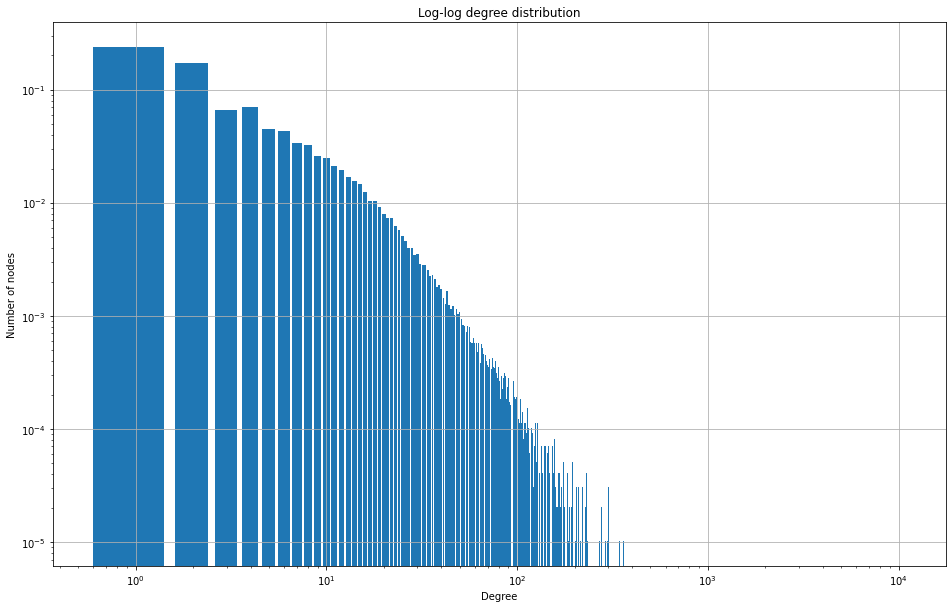

In [17]:
g.plot_degree_distro(normalize=True, log=True)

<br>

## Question2 ~ Pages reached in given number of clicks

For this question we have used the same principle as the **BFS**, but have slightly modified it so that we could keep track of the pages seen in a set of clicks. 

In [18]:
pages_seen = g.pages_in_click(initial_page=95, num_clicks=5)

In [19]:
pages_seen[:20]

[1245201,
 655377,
 1245212,
 655392,
 1376294,
 1376295,
 1048636,
 1048637,
 1048638,
 65596,
 1048648,
 1048658,
 1048660,
 1179733,
 655451,
 655471,
 1245303,
 1048710,
 1179783,
 1179786]

In [20]:
print('Total number of articles visited:', '\033[1m', len(pages_seen), '\033[0m')

Total number of articles visited:  16726 


<br>

## Question 3 ~ Minimum number of clicks within a category

In this task, we choose an arbitrary category $C$ and we try to approximate the minimum number of clicks needed to reach all the pages in $C$ starting from a source vertex $v$, i.e the minimum walk from $v$ to all the other vertices. 

In the literature, this problem is known as the Travelling Salesman Problem, which constists in finding a Hamiltonian cycle in the graph. Since the graph we are working on is directed, we deal with the asymmetric version of TSP. 

TSP is proved to be NP-hard, that is no exact solution to it an be provided in polynomial time.

In our case, we are asked only to try to find an approximation of it, also dropping the constraint of the single-visit of each vertex.

The fact that the graph is directed and sparse makes the finding of a feasible path harder: the most of the algorithms for approximating the TSP problem are thought for undirected graphs and a directed sparse graph can't be trivially treated as an undirected one.

Nevertheless, from the original graph we build a new graph having these properties:
- the vertices are those in the category $C$;
- each pair $(u,v)$ of nodes is connected by an edge if and only if a path from $u$ to $v$ exists in the original graph $G$; each edge is weighted with the minimum distance from u to v in $G$.

Then, we run the [Nearest Neightbor algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) to find a path. This heuristic is known to yield on average a path that is $25\%$ longer than the optimal one. Moreover, on a directed sparse graph, as we can see running the algorithm on different categories, it often doesn't even find a feasible path through all the vertices. This case happens, for example, when a vertex with no outcoming edges is not selected as the last vertex to visit; it also happens when all the outcoming edges from the currently selected vertex lead to already visited vertices. Anyway, it is a fast and easy heuristic.

Following the strategy mentioned above, we first load the categories of the graph. 

In [21]:
categories = funcs.read_graph_category(g)

The categories and the number of articles in each are:

In [22]:
print([(c,len(categories[c])) for c in categories.keys()])

[('American_film_actors', 9134),
 ('American_films', 7473),
 ('American_television_actors', 6438),
 ('Association_football_defenders', 2146),
 ('Association_football_forwards', 2490),
 ('Association_football_midfielders', 2769),
 ('Asteroids_named_for_people', 2329),
 ('Black-and-white_films', 5208),
 ('Debut_albums', 2553),
 ('English-language_films', 13401),
 ('English_footballers', 3605),
 ('Harvard_University_alumni', 2963),
 ('Indian_films', 2729),
 ('Main_Belt_asteroids', 8669),
 ('Major_League_Baseball_pitchers', 3307),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 6430),
 ('Place_of_birth_missing_(living_people)', 2543),
 ('Rivers_of_Romania', 7662),
 ('The_Football_League_players', 3645),
 ('Year_of_birth_missing', 1487),
 ('Year_of_death_missing', 1362)]

We then choose a random category and we compute the Nearest Neighbor algorithm starting from the most *in-degree* central vertex in the category.

In [23]:
import random
category = list(categories.keys())[random.randint(0, 20)]
print(category)

'Association_football_forwards'

In [24]:
g.minimum_cat_walk(categories[category])

  0%|          | 2/2490 [00:00<03:35, 11.52it/s]

Calculating the distances between each pair of vertices in the graph...


100%|██████████| 2490/2490 [03:59<00:00, 10.40it/s]


Calculating the source vertex according to the in-degree centrality measure...
The source vertex is:	88160
Not possible!


<br>

## Question 4 ~ Min Max Cut Algorithm

The algorithm used for this approach is the max flow algorithm, specifically using the Ford–Fulkerson algorithm, i.e. the augmented paths that we inspect to find the max flow are not generated randomly (this would be the Edmonds–Karp algorithm) but they are generated using the BFS approach. 

The main idea behind this algorithm is to compute the maximum capacity we can push from one node (source) to another (sink). It can be proven that this capacity is equal to the minimum number of edges required to disconnect source and sink. We will re-use this approach to obtain the minimum number of edges to cut, and also the exact set of edges required for this purpose. 

The algorithm works as follows:

1. Construct capacity of the graph (in our unweighted graph we will  have capacity of 1 between all connected edges). The same algorithm also applies for weighted graphs.
2. Find shortest path/flow between source and sink using BFS.
3. Reduce the capacity of the edges through which we have set the first flow.
4. Repeat BFS algorithm, but this time taking into account that we cannot cross an edge with capacity 0.
5. Whenever the BFS algorithm is stopped due to the fact that the capacity is 0, we will store this "funnel_edge" since this edge will allow us to disconnect source and sink.
6. This is repeated until no more BFS paths can be found. The final edges are computed considering funnel edges, and paths without funnel edges.

In [25]:
category1 = 'Living_people'
category2 = 'American_film_actors'

random_articles = set(final_pages_category[category1] + 
                      final_pages_category[category2])

KeyError: 'Living_people'

In [88]:
induced_subgraph = g.generate_induced_subgraph(random_articles)

In [114]:
edges_to_cut, min_cut = induced_subgraph.max_flow_func(1057994, 1062380)
print('Edges to be cut:', edges_to_cut)

Flow: [1057994, 1061853, 1061905, 1062335, 1060969, 1062597, 1062380]
[[1057994, 1061853, 1061905, 1062335, 1060969, 1062597, 1062380]]


[]

<br>

## Question 5 ~ Sort categories

In this task we are asked to sort all other categories according to their distances from a given category. The distance between two categories is defined as the median of the distances between each pair of nodes in the two categories.

As a first step, we load the categories of the graph:

In [26]:
categories = funcs.read_graph_category(g)

At this point, we compute the category distances:

In [27]:
sorted_cat = g.category_distance(category, categories)

100%|██████████| 2490/2490 [03:38<00:00, 11.38it/s]


Finally, we show the categories sorted by their distances. The order between categories with the same distance is arbitrary.

In [28]:
sorted_cat

['American_film_actors',
 'American_films',
 'American_television_actors',
 'Black-and-white_films',
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
 'English-language_films',
 'Rivers_of_Romania',
 'The_Football_League_players',
 'Place_of_birth_missing_(living_people)',
 'Major_League_Baseball_pitchers',
 'Main_Belt_asteroids',
 'English_footballers',
 'Harvard_University_alumni',
 'Year_of_birth_missing',
 'Debut_albums',
 'Asteroids_named_for_people',
 'Association_football_midfielders',
 'Association_football_defenders',
 'Indian_films',
 'Year_of_death_missing']

<br>

## Question 6 ~ PageRank

The first step for this algorithm is to model our graph based on the categories, i.e. we will convert our graph, that is at article level, into a weigthed and directed graph at category level. In order to do this we will compute the number of articles from one category that link to articles from another category. Doing this over all articles we can get our final category network.

Once this is done we will apply the RageRank algorithm over this graph, which works as following:

1. Compute the probability of starting out at any category (all categories will have the same initial probability)
2. Compute a matrix (since it would result in a sparse matrix we have decided to convert it into a dictionary, but the principle is the same) which given a catgory, computes the probability of acutally reaching that category from its neighbouring categories (this matrix will be represented as X for our purpose).
3. Multiplying this matrix over the initial probabilities of being at a certain category, and iterating over this multiplication until convergence, we can compute the final PageRank score as follows:

\begin{align}
PR(x)^{t+1} = \frac{1-\lambda}{N} + \lambda*\bigg(\sum_{y -> x}\frac{PR^{t}(y)}{X(y)} \bigg)
\end{align}

where we apply this over all nodes. The can be interpreted as the sum over all y nodes that have an inlink to the node x.

Convergence is reached when $PR(t+1) \approx PR(t)$  

In [29]:
category_graph_weighted = g.category_model_network_weighted(unique_category)

In [45]:
page_rank_score = g.page_rank(category_graph_weighted, max_iter = 1000, tolerance=.0000001, top=50)

Converged in 45 iterations


In [46]:
page_rank_score

,Page Rank Score
Living_people,0.039134
American_film_actors,0.035795
English-language_films,0.026047
American_television_actors,0.021057
American_films,0.019200
Members_of_the_United_Kingdom_Parliament_for_English_constituencies,0.009954
Black-and-white_films,0.008471
The_Football_League_players,0.007691
American_stage_actors,0.007250
English_footballers,0.006679
